In [1]:
### https://anaconda.org/anaconda/py-xgboost
### Importando as libs
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import confusion_matrix, mean_squared_error
import pylab as pl
from sklearn import model_selection
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

# Scripts

In [2]:
def forward_feature_construction(colunasx,colunasy):
    ### Config
    size = len(colunasx)
    lista = list()
    for id in  range(1,size):
        for x in  combinations(colunasx,r=id):
            lista.append(list(x))
        ### Resampling
    return lista    

In [3]:
def predict(lista, train, colunasy,teste_size,scan):
   
    ### Config Default
    colunas=['Classe','FamiliaQtde','PassagemPreco','SexoNum','SaudacaoNum']
    seed = 9
    max_depth=3
    min_child_weight=1
    
    seed_it = seed
    max_depth_it=max_depth
    min_child_weight_it=min_child_weight
    
    ### Config Final
    colunas_final=[]
    max_depth_final=0
    seed_final=0
    acertos_final=0
    min_child_weight_final=0
    
    
    resultXGBClassifier=0
    
    print('#####################################################')
    print('################# RESULTADOS ########################')
    print('#####################################################')
                
    if scan:
#        for min_child_weight_it in  range(1,3):
#            for max_depth_it in  range(0,10):
#                for seed_it in  range(1,15):
                    for colunasx_it in  lista:
                        ### Slice
                        x_treino, x_teste, y_treino, y_teste = model_selection.train_test_split(train[colunasx_it],train[colunasy],test_size=teste_size,random_state=seed_it)
                        ### Modelo - Treino
                        xgb_model = xgb.XGBClassifier(max_depth=max_depth_it,min_child_weight=min_child_weight_it).fit(x_treino, y_treino)
                        ### Modelo - Predict
                        predictions = xgb_model.predict(x_teste)

                        ### Confusion Matrix
                        actuals = y_teste
                        #print(colunasx)
                        #print(confusion_matrix(actuals, predictions))
                        previsto = pd.DataFrame({'previsto':predictions},index=actuals.index)
                        resultadoErros =       previsto.loc[previsto['previsto'].values != actuals['Sobreviventes'].values]
                        resultadoAcertos =     previsto.loc[previsto['previsto'].values == actuals['Sobreviventes'].values]
                        pontuacao=(xgb_model.score(x_teste,y_teste)*100.0)
                        
                        if resultadoAcertos.size >= acertos_final and pontuacao >84 :
                            ### Score
                            resultXGBClassifier = pontuacao
                            ### Resultado Final
                            max_depth_final=max_depth_it
                            seed_final=seed_it
                            colunas_final=colunasx_it
                            acertos_final=resultadoAcertos.size
                            erros_final=resultadoErros.size
                            min_child_weight_final=min_child_weight
                            
                            print('Score XGBClassifier:',resultXGBClassifier)
                            print('acertos:',resultadoAcertos.size)
                            print('erros:',resultadoErros.size)
                            print('colunas:',colunas_final)
                            print('seed:',seed_final)
                            print('max_depth_final:',max_depth_final)
                            print('min_child_weight_final:',min_child_weight_final)
                            print('#####################################################')
    else:
        ### Slice
        x_treino, x_teste, y_treino, y_teste = model_selection.train_test_split(train[colunas],train[colunasy],test_size=teste_size,random_state=seed)
        ### Modelo - Treino
        xgb_model = xgb.XGBClassifier(max_depth=max_depth,min_child_weight=min_child_weight).fit(x_treino, y_treino)
        ### Modelo - Predict
        predictions = xgb_model.predict(x_teste)
        ### Score
        resultXGBClassifier = xgb_model.score(x_teste,y_teste)
        actuals = y_teste
        previsto = pd.DataFrame({'previsto':predictions},index=actuals.index)
        resultadoErros =       previsto.loc[previsto['previsto'].values != actuals['Sobreviventes'].values]
        resultadoAcertos =     previsto.loc[previsto['previsto'].values == actuals['Sobreviventes'].values]
        ### Resultado Final
        max_depth_final=max_depth
        seed_final=seed
        colunas_final=colunas
        acertos_final=resultadoAcertos.size
        min_child_weight_final=min_child_weight
    
    print('#####################################################')
    print('############### RESULTADOS FINAL ####################')
    print('#####################################################')
    print('Score XGBClassifier:',resultXGBClassifier)
    print('acertos:',acertos_final)
    print('erros:',erros_final)
    print('colunas=',colunas_final)
    print('seed=',seed_final)
    print('max_depth_final=',max_depth_final)
    print('min_child_weight_final=',min_child_weight_final)
        
    #print('Predict',x_teste_dropna.shape)    
    return (acertos_final,colunas_final,seed_final,max_depth_final,min_child_weight_final)


    

# Coleta de dados

## Fontes

In [4]:
### Coletando as fontes de dados
test_csv = pd.read_csv('r_teste.csv', sep = ',', encoding = 'UTF-8',header='infer')
train_csv = pd.read_csv('r_treino.csv', sep = ',', encoding = 'UTF-8',header='infer')
train_dropna_csv = pd.read_csv('r_treino_dropna.csv', sep = ',', encoding = 'UTF-8',header='infer')

In [5]:
train_dropna_csv.head(2)

,PassageiroId,Classe,PortoEmbarqueNum,ParentesIrmao,ParentesFilhos,SexoNum,SaudacaoNum,PassagemPreco,FamiliaQtde,EstaSozinho,TemCabine,Sobreviventes
0,1,3,1,1,0,1,0,7.2500,1,0.0,0.0,0
1,2,1,2,1,0,0,1,71.2833,1,0.0,1.0,1


In [6]:
colunasx=[
    'Classe',
    #'PortoEmbarqueNum',
    #'ParentesIrmao',
    'ParentesFilhos',
    'SexoNum',
    'SaudacaoNum',
    'PassagemPreco',
    'FamiliaQtde',
    'EstaSozinho',
    'TemCabine'
]
colunasy=['Sobreviventes']

In [7]:
colunas = forward_feature_construction(colunasx,colunasy)

In [8]:
train= train_dropna_csv
#train= train_csv

train=train.set_index(train['PassageiroId'])

In [9]:
### Config
teste_size=0.30 ##30%

In [10]:
acertos,colunas,seed,max_depth,min_child_weight=predict(colunas, train, colunasy,teste_size,True)
#87.44186046511628

#####################################################
################# RESULTADOS ########################
#####################################################
Score XGBClassifier: 84.18604651162791
acertos: 181
erros: 34
colunas: ['SaudacaoNum', 'PassagemPreco', 'FamiliaQtde']
seed: 9
max_depth_final: 3
min_child_weight_final: 1
#####################################################
Score XGBClassifier: 84.18604651162791
acertos: 181
erros: 34
colunas: ['SaudacaoNum', 'PassagemPreco', 'FamiliaQtde', 'EstaSozinho']
seed: 9
max_depth_final: 3
min_child_weight_final: 1
#####################################################
Score XGBClassifier: 84.18604651162791
acertos: 181
erros: 34
colunas: ['Classe', 'SexoNum', 'SaudacaoNum', 'PassagemPreco', 'FamiliaQtde']
seed: 9
max_depth_final: 3
min_child_weight_final: 1
#####################################################
Score XGBClassifier: 84.18604651162791
acertos: 181
erros: 34
colunas: ['Classe', 'SexoNum', 'SaudacaoNum', 'PassagemPreco',

# Resultado Final

In [11]:
#colunas= ['Classe', 'SexoNum', 'SaudacaoNum', 'PassagemPreco', 'FamiliaQtde', 'EstaSozinho']
x_treino, x_teste, y_treino, y_teste = model_selection.train_test_split(train[colunas],train[colunasy],test_size=teste_size,random_state=seed)

In [12]:
xgb_model = xgb.XGBClassifier(max_depth=max_depth,min_child_weight=min_child_weight).fit(x_treino, y_treino)
#xgb_model = xgb.XGBClassifier(n_estimators=1000).fit(x_treino, y_treino)

In [13]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [14]:
y_pred_dropna = xgb_model.predict(test_csv[colunas])

In [15]:
submission = pd.DataFrame({
        "PassengerId": test_csv["PassageiroId"],
        "Survived": y_pred_dropna
    })
submission.to_csv('resultXGBClassifier_dropna.csv', index=False)

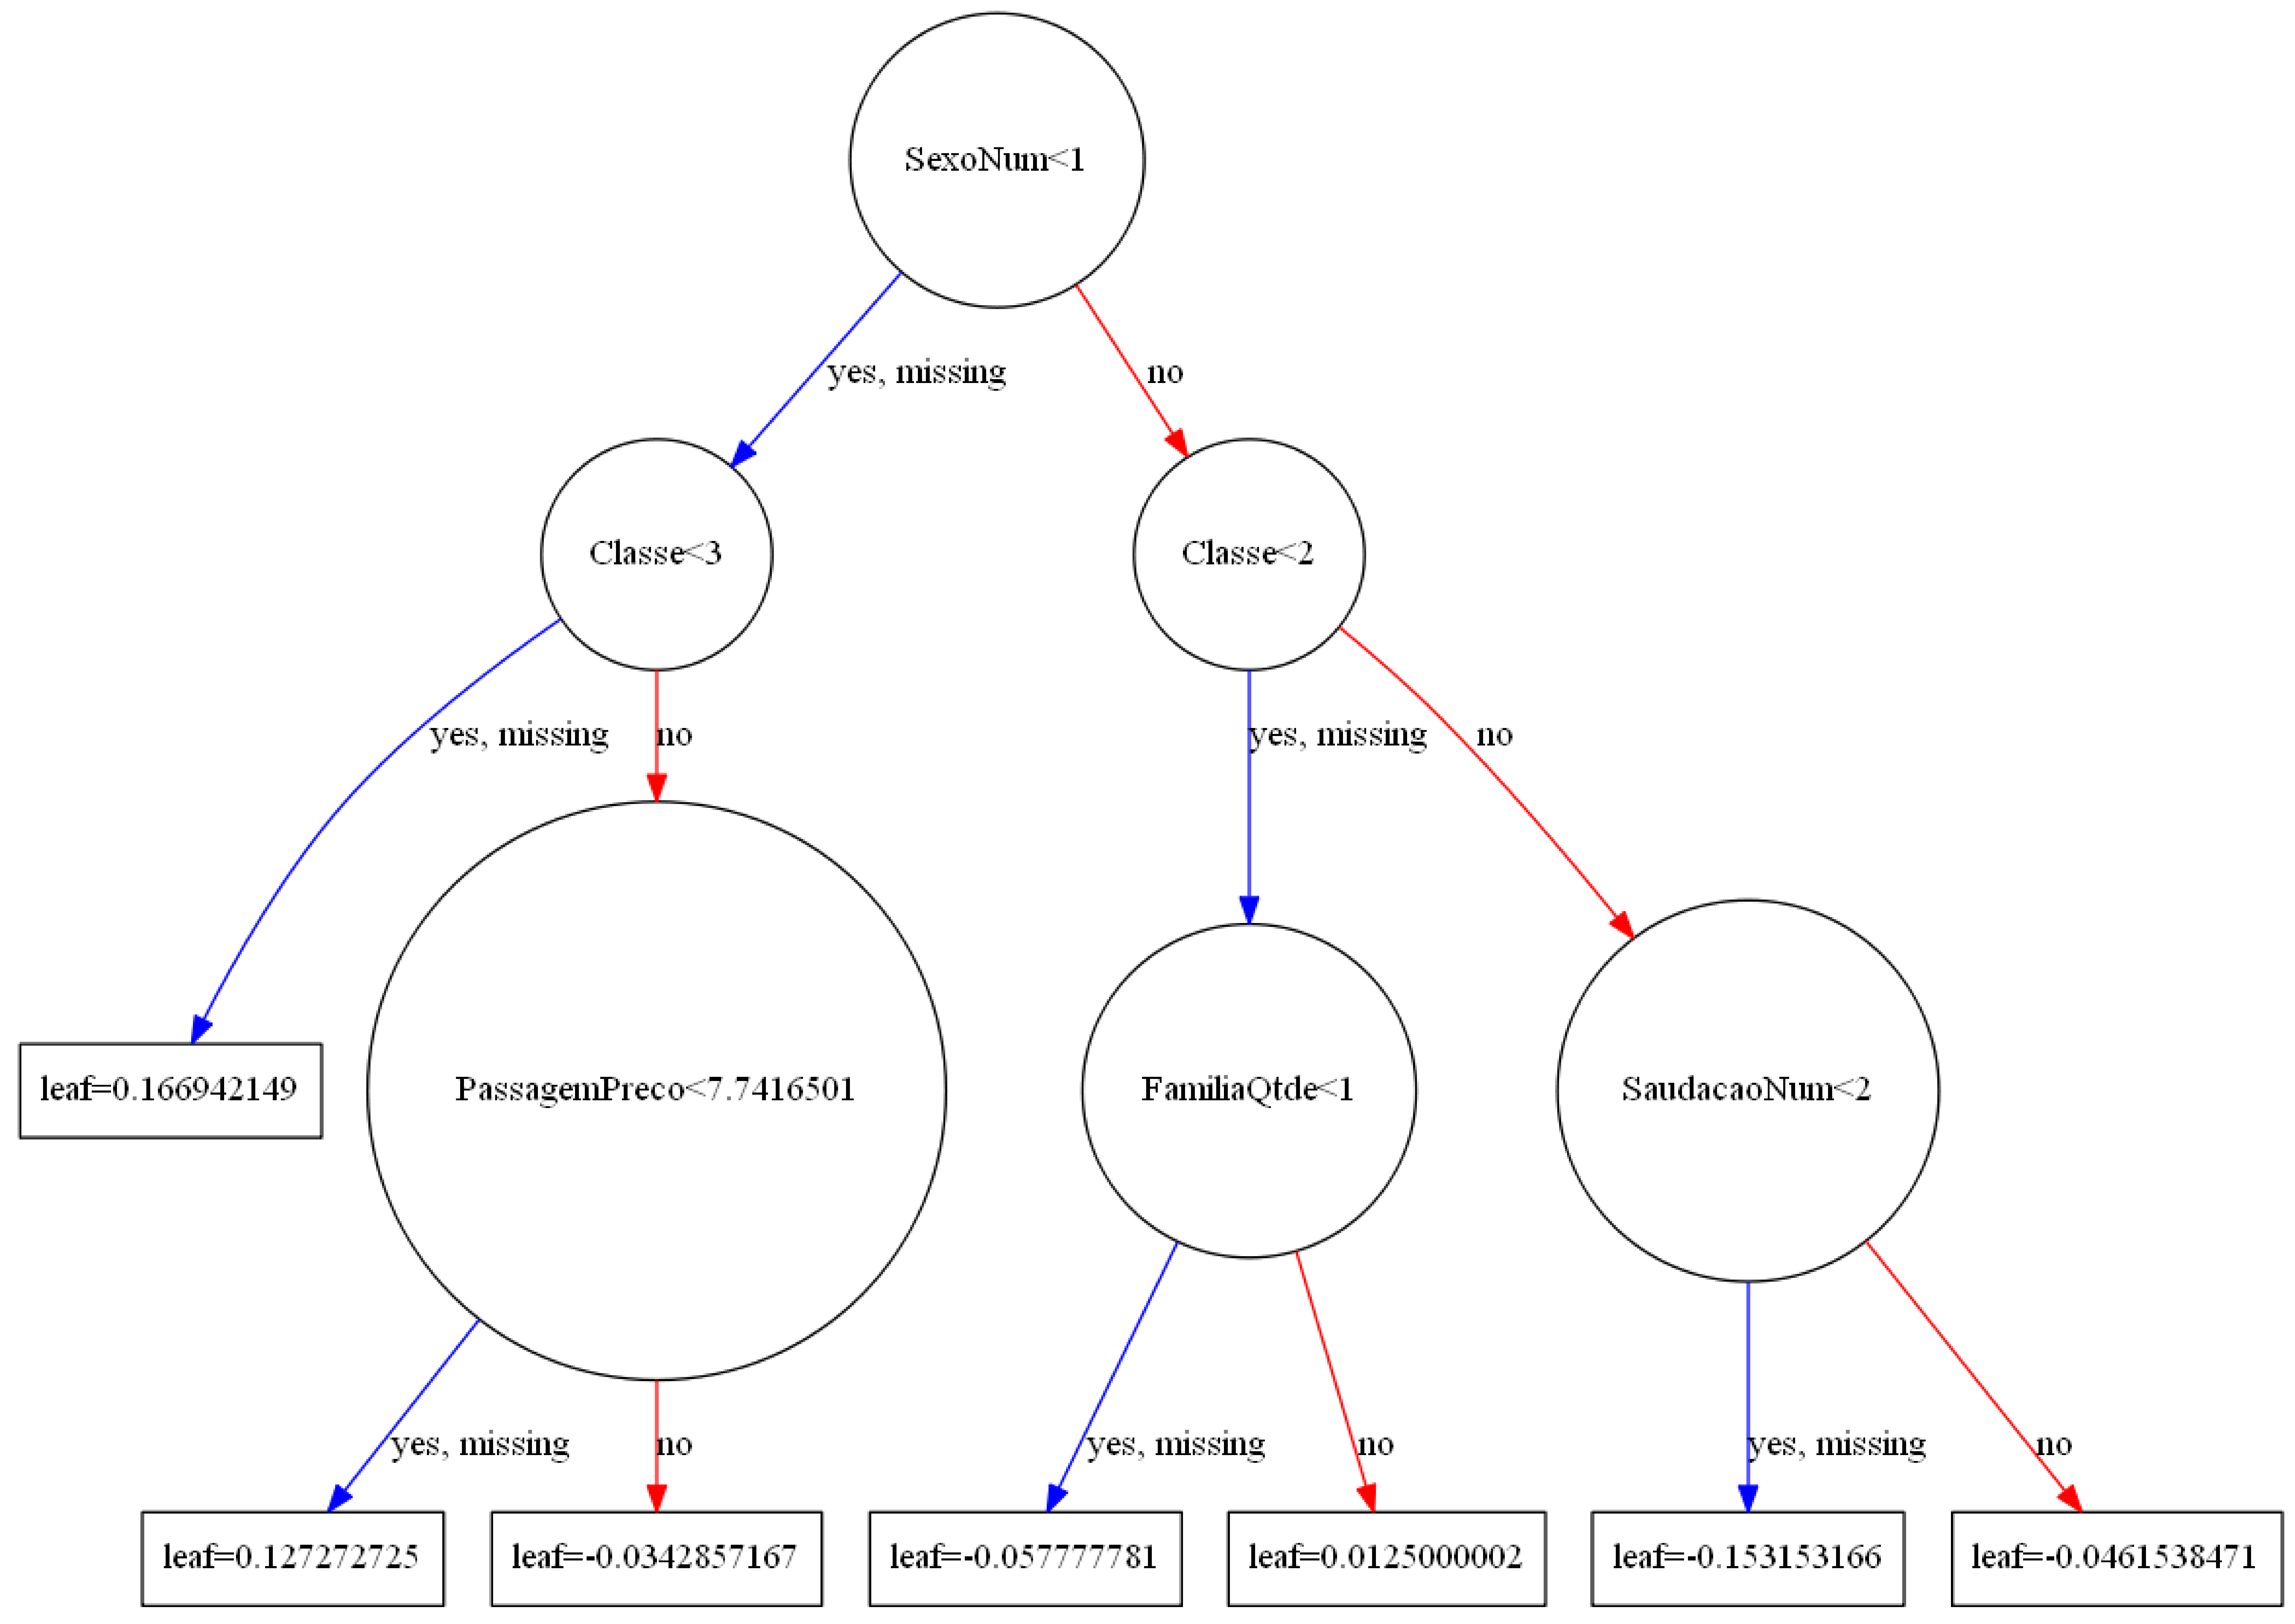

In [16]:
xgb.plot_tree(xgb_model)
fig = pl.gcf()
fig.set_size_inches(150, 100)